# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

C:\Users\Влад\AppData\Local\Temp\ipykernel_13024\2810386256.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
C:\Users\Влад\AppData\Local\Temp\ipykernel_13024\2810386256.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for layer: 0; param: W
Gradient check passed!
Checking gradient for layer: 0; param: B
Gradient check passed!
Checking gradient for layer: 2; param: W
Gradient check passed!
Checking gradient for layer: 2; param: B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e-2)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for layer: 0; param: W
Gradient check passed!
Checking gradient for layer: 0; param: B
Gradient check passed!
Checking gradient for layer: 2; param: W
Gradient check passed!
Checking gradient for layer: 2; param: B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.278866, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, Loss: 2.251895, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.242700, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.239080, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.236805, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.234059, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.229410, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.218639, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.200722, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.180721, Train accuracy: 0.206222, val accuracy: 0.208000
Epoch: 10, Loss: 2.163152, Train accuracy: 0.226111, val accuracy: 0.225000
Epoch: 11, Loss: 2.148388, Train accuracy: 0.238778, val accuracy: 0.243000
Epoch: 12, Loss: 2.135467, Train accuracy: 0.253889, val accuracy: 0.253000
Epoch: 13, Loss: 2.122

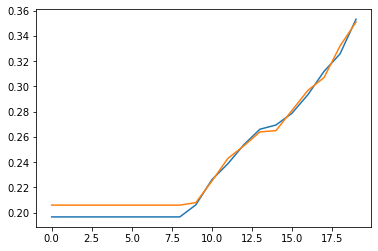

In [10]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0, Loss: 2.278593, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, Loss: 2.251419, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.242392, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.238713, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.236403, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.233886, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.229141, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.219055, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.202580, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.184010, Train accuracy: 0.199111, val accuracy: 0.208000
Epoch: 10, Loss: 2.166855, Train accuracy: 0.212000, val accuracy: 0.217000
Epoch: 11, Loss: 2.153070, Train accuracy: 0.233444, val accuracy: 0.236000
Epoch: 12, Loss: 2.140393, Train accuracy: 0.247333, val accuracy: 0.247000
Epoch: 13, Loss: 2.128

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.302241, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, Loss: 2.295443, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.289403, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.284045, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.279292, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.275079, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.271333, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.268012, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.265062, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.262438, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, Loss: 2.260103, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, Loss: 2.258022, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, Loss: 2.256164, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, Loss: 2.254

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.338513, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 1, Loss: 2.320917, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 2, Loss: 2.309354, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 3, Loss: 2.302162, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 4, Loss: 2.291612, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 5, Loss: 2.279376, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 6, Loss: 2.272259, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 7, Loss: 2.249074, Train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 8, Loss: 2.224796, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 9, Loss: 2.160366, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 10, Loss: 2.077119, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 11, Loss: 2.023314, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 12, Loss: 1.990641, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 13, Loss: 1.882

Epoch: 108, Loss: 1.296569, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch: 109, Loss: 1.298800, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 110, Loss: 1.305147, Train accuracy: 1.000000, val accuracy: 0.066667
Epoch: 111, Loss: 1.292964, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 112, Loss: 1.294184, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 113, Loss: 1.283020, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 114, Loss: 1.286336, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 115, Loss: 1.311874, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 116, Loss: 1.307945, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 117, Loss: 1.278573, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 118, Loss: 1.274128, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 119, Loss: 1.299602, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 120, Loss: 1.308194, Train accuracy: 0.933333, val accuracy: 0.000000

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [14]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 200, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(
    model,
    dataset,
    SGD(),
    learning_rate=1e-1,
    learning_rate_decay=0.9999,
    num_epochs=20,
    batch_size=2
)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.322112, Train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 1, Loss: 2.300698, Train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 2, Loss: 2.253876, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 3, Loss: 2.194583, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 4, Loss: 1.803323, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 5, Loss: 2.010794, Train accuracy: 0.466667, val accuracy: 0.000000
Epoch: 6, Loss: 1.670778, Train accuracy: 0.466667, val accuracy: 0.000000
Epoch: 7, Loss: 1.674450, Train accuracy: 0.400000, val accuracy: 0.066667
Epoch: 8, Loss: 1.752120, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 9, Loss: 1.896332, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 10, Loss: 1.531563, Train accuracy: 0.666667, val accuracy: 0.000000
Epoch: 11, Loss: 1.212442, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 12, Loss: 1.097441, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 13, Loss: 1.430

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [15]:
# Let's train the best one-hidden-layer network we can

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

dataset = Dataset(train_X, train_y, val_X, val_y)


def get_accuracy_for_TwoLayerNet_with_params(
    hidden_layer_size_in_use,
    reg_strength_in_use,
    learning_rate_in_use,
    learning_rate_decay_in_use,
    batch_size_in_use,
    num_epochs_in_use
):
    model = TwoLayerNet(
        n_input = train_X.shape[1],
        n_output = 10,
        hidden_layer_size = hidden_layer_size_in_use,
        reg = reg_strength_in_use
    )
    trainer = Trainer(
        model,
        dataset,
        MomentumSGD(),
        learning_rate=learning_rate_in_use,
        learning_rate_decay=learning_rate_decay_in_use,
        batch_size=batch_size_in_use,
        num_epochs=num_epochs_in_use
    )
    loss_history, train_history, val_history = trainer.fit(False)
    return max(val_history)

In [16]:
# search best hyper params

best_params = [128, 1e-3, 1e-2, 0.999, 64, 50]  # standard params

hidden_layer_sizes = [64, 96, 128, 172, 256]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
learning_rates_decay = [0.9, 0.99, 0.999, 0.9999, 1]
batch_sizes = [16, 64, 128, 256, 512]
num_epochs = [25, 50, 75]
hyper_params = {
    'hidden_layer_size': hidden_layer_sizes,
    'reg_strength': reg_strengths,
    'learning_rate': learning_rates,
    'learning_rate_decay': learning_rates_decay,
    'batch_size': batch_sizes,
    'num_epoch': num_epochs,
}
dict_hp = {name_param: {} for name_param in hyper_params}
index = 0
for name_param, hyper_param_list in hyper_params.items():
    print(name_param)
    for hyper_param in hyper_param_list:
        use_params = best_params.copy()
        use_params[index] = hyper_param
        val_accuracy = get_accuracy_for_TwoLayerNet_with_params(*use_params)
        print(f'{hyper_param}\t<=>\t{val_accuracy}')
        dict_hp[name_param].update({hyper_param: val_accuracy})
    max_accuracy = 0
    for hyper_param, val_accuracy in dict_hp[name_param].items():
        if val_accuracy > max_accuracy:
            best_params[index] = hyper_param
            max_accuracy = val_accuracy
    index += 1

hidden_layer_size
64	<=>	0.762
96	<=>	0.762
128	<=>	0.766
172	<=>	0.772
256	<=>	0.766
reg_strength
0.1	<=>	0.206
0.01	<=>	0.667
0.001	<=>	0.768
0.0001	<=>	0.769
1e-05	<=>	0.76
learning_rate
0.1	<=>	0.732
0.01	<=>	0.768
0.001	<=>	0.379
0.0001	<=>	0.206
1e-05	<=>	0.206
learning_rate_decay
0.9	<=>	0.655
0.99	<=>	0.769
0.999	<=>	0.772
0.9999	<=>	0.776
1	<=>	0.783
batch_size
16	<=>	0.76
64	<=>	0.769
128	<=>	0.751
256	<=>	0.705
512	<=>	0.484
num_epoch
25	<=>	0.735
50	<=>	0.772
75	<=>	0.777


In [17]:
# show best hyper params
index = 0
print('best hyper params:')
for name_param in hyper_params:
    print(f'{name_param}\t<=>\t{best_params[index]}')
    index += 1

best hyper params:
hidden_layer_size	<=>	172
reg_strength	<=>	0.0001
learning_rate	<=>	0.01
learning_rate_decay	<=>	1
batch_size	<=>	64
num_epoch	<=>	75


In [18]:
# create best classifier

dataset = Dataset(train_X, train_y, val_X, val_y)
best_classifier = TwoLayerNet(
    n_input = train_X.shape[1],
    n_output = 10,
    hidden_layer_size = best_params[0],
    reg = best_params[1]
)
trainer = Trainer(
    best_classifier,
    dataset,
    MomentumSGD(),
    learning_rate=best_params[2],
    learning_rate_decay=best_params[3],
    batch_size=best_params[4],
    num_epochs=best_params[5]
)
loss_history, train_history, val_history = trainer.fit(True)
best_val_accuracy = max(val_history)


Epoch: 0, Loss: 2.397349, Train accuracy: 0.222778, val accuracy: 0.230000
Epoch: 1, Loss: 2.151361, Train accuracy: 0.320889, val accuracy: 0.318000
Epoch: 2, Loss: 2.026317, Train accuracy: 0.386778, val accuracy: 0.384000
Epoch: 3, Loss: 1.938375, Train accuracy: 0.443222, val accuracy: 0.434000
Epoch: 4, Loss: 1.882960, Train accuracy: 0.483556, val accuracy: 0.478000
Epoch: 5, Loss: 1.847732, Train accuracy: 0.516444, val accuracy: 0.520000
Epoch: 6, Loss: 1.822118, Train accuracy: 0.522000, val accuracy: 0.535000
Epoch: 7, Loss: 1.806241, Train accuracy: 0.568889, val accuracy: 0.573000
Epoch: 8, Loss: 1.794000, Train accuracy: 0.575667, val accuracy: 0.582000
Epoch: 9, Loss: 1.783579, Train accuracy: 0.596333, val accuracy: 0.596000
Epoch: 10, Loss: 1.782143, Train accuracy: 0.624111, val accuracy: 0.621000
Epoch: 11, Loss: 1.769676, Train accuracy: 0.620000, val accuracy: 0.611000
Epoch: 12, Loss: 1.766583, Train accuracy: 0.630333, val accuracy: 0.613000
Epoch: 13, Loss: 1.763

best validation accuracy achieved: 0.677000


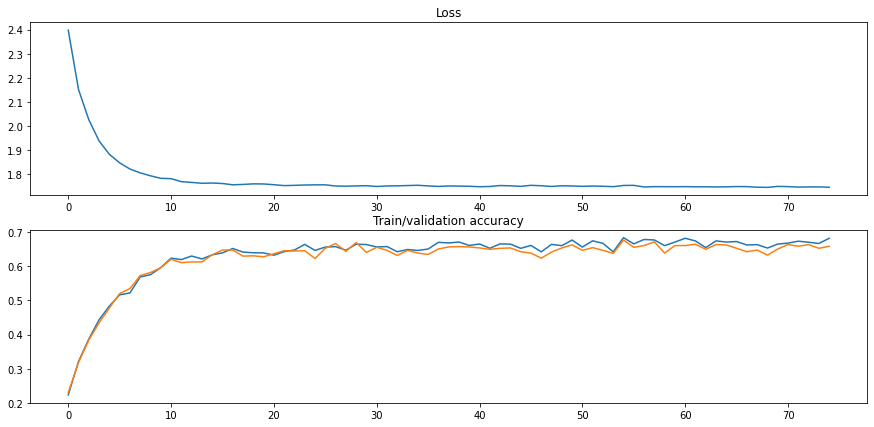

In [19]:
print('best validation accuracy achieved: %f' % best_val_accuracy)

plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [20]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.062000


best validation accuracy achieved: 0.735000
Neural net test set accuracy: 0.677000


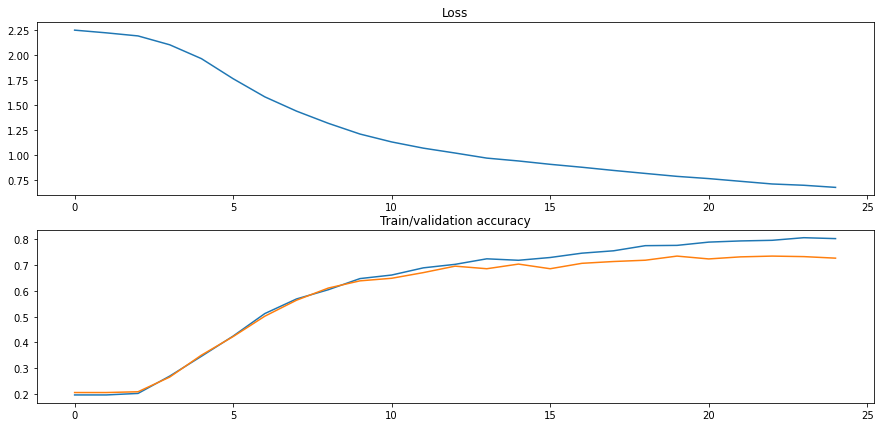

In [8]:
# overfit has been received, let's fix it

try_params = [172, 1e-4, 1e-2, 1, 64, 25]

dataset = Dataset(train_X, train_y, val_X, val_y)
best_classifier = TwoLayerNet(
    n_input = train_X.shape[1],
    n_output = 10,
    hidden_layer_size = try_params[0],
    reg = try_params[1]
)
trainer = Trainer(
    best_classifier,
    dataset,
    MomentumSGD(),
    learning_rate=try_params[2],
    learning_rate_decay=try_params[3],
    batch_size=try_params[4],
    num_epochs=try_params[5]
)
loss_history, train_history, val_history = trainer.fit(False)
best_val_accuracy = max(val_history)
print('best validation accuracy achieved: %f' % best_val_accuracy)

test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)